In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import StandardScaler, VectorAssembler
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from pyspark.sql.functions import col
import seaborn as sns
from pyspark import StorageLevel

In [2]:
spark = SparkSession \
        .builder \
        .master('spark://10.10.28.172:7077') \
        .appName('visualizing') \
        .enableHiveSupport() \
        .getOrCreate()

spark.sql('use twitter_data')
spark.sql('show tables').show()

22/04/26 15:22:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/26 15:22:09 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
22/04/26 15:22:09 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
22/04/26 15:22:13 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


+------------+--------------------+-----------+
|    database|           tableName|isTemporary|
+------------+--------------------+-----------+
|twitter_data|      processed_data|      false|
|twitter_data|            raw_data|      false|
|twitter_data|             results|      false|
|twitter_data|    textblob_results|      false|
|twitter_data|       vader_results|      false|
|twitter_data|wordlist2477_results|      false|
+------------+--------------------+-----------+



In [3]:
# scaling takes much longer. probably due to the large float numbers
COMBINE = True  # if you want to combine all sentiment scores (after grouping)
INTERVAL = '1 week'
ANALYSERS_TO_PLOT = ['vader_sentiment', 'textblob_sentiment', 'wordlist2477_sentiment']
# interval = '6 hours'


# Get data
query = '''
    SELECT created_at, vader_sentiment, textblob_sentiment, wordlist2477_sentiment
    FROM results
'''

df = spark.sql(query)
org_df = df
df.printSchema()

root
 |-- created_at: timestamp (nullable = true)
 |-- vader_sentiment: float (nullable = true)
 |-- textblob_sentiment: float (nullable = true)
 |-- wordlist2477_sentiment: integer (nullable = true)



## Functions

In [4]:
senti_cols = [col(f'avg({c})') for c in ANALYSERS_TO_PLOT]
average_senti = sum(s_score for s_score in senti_cols)/len(senti_cols)

# Plot with sns to control number of x ticks
def plot_events_sns(df, start_date, end_date, axes_i, title, analysers, combine=True, x_tick_dist=2, xlab_rot=90, labels='%Y-%m-%d'):
    query = """CAST(window.start AS INT)
            BETWEEN unix_timestamp('{0}', 'yyyy-MM-dd HH:mm:ss')
            AND unix_timestamp('{1}', 'yyyy-MM-dd HH:mm:ss')""".format(start_date,end_date)

    df = df.where(query)

    cols = ['window'] + analysers
    results = df.select(cols)
    if combine:
        results = results.\
            withColumn('avg_sentiment', average_senti) \
            .select('window', 'avg_sentiment')

    pandas_df = results. \
        withColumn('window', F.col('window').start). \
        sort('window', ascending=True). \
        withColumnRenamed('window', 'interval'). \
        toPandas().set_index('interval')

    # Seaborn + formatter code
    x_date = mdates.datestr2num(pandas_df.index.astype(str))

    xfmt = mdates.DateFormatter(labels)
    
    sns.lineplot(ax=axes_i, data=pandas_df)
    axes_i.set_title(title)
    axes_i.xaxis.set_major_formatter(xfmt)
    axes_i.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    axes_i.set_xticks(np.arange(x_date.min(), x_date.max(), x_tick_dist))
    axes_i.tick_params(axis='x', labelrotation=xlab_rot)



def plot_events(df, start_date, end_date, interval=INTERVAL, combine=True):
    query = """CAST(created_at AS INT)
            BETWEEN unix_timestamp('{0}', 'yyyy-MM-dd HH:mm:ss')
            AND unix_timestamp('{1}', 'yyyy-MM-dd HH:mm:ss')""".format(start_date,end_date)

    df = df.where(query)

    cols = ['created_at'] + ANALYSERS_TO_PLOT
    results = df. \
        select(cols). \
        groupBy(F.window('created_at', interval)). \
        mean()

    if combine:
        results = results.\
            withColumn('avg_sentiment', average_senti) \
            .select('window', 'avg_sentiment')

    results. \
        withColumn('window', F.col('window').start). \
        sort('window', ascending=True). \
        withColumnRenamed('window', 'interval'). \
        toPandas(). \
        set_index('interval'). \
        plot()

## Scale Sentiment Scores to Make Comparable
The scaling was performed with the standardScaler from pyspark with the following formula:  

μ = mean of variable,  
σ = standard deviation,


x_standarized = (μ - x_i)/σ


In [5]:
print('Performing Scaling')
sentiment_cols = [x for x, datatype in df.dtypes if datatype != 'timestamp']

vector_asse = VectorAssembler(inputCols=sentiment_cols, outputCol='sentiment_combined')
temp_df = vector_asse.transform(df)

scaler = StandardScaler(inputCol='sentiment_combined', outputCol='scaled_sentiment')
df = scaler.fit(temp_df).transform(temp_df)

# Function just to convert to help build data frame
col_names = ['vader_sentiment','textblob_sentiment','wordlist2477_sentiment','created_at']

def extract(row):
  return row.scaled_sentiment.toArray().tolist() + [row.created_at]

scaled_df = df.select(['created_at','scaled_sentiment']).rdd.map(extract).toDF(col_names)
# Get interval average of scaled df
scaled_df = scaled_df. \
            select(col_names). \
            groupBy(F.window('created_at', INTERVAL)). \
            mean()

# Force Spark to keep DF in memory
scaled_df.persist(StorageLevel.MEMORY_ONLY)
# Transform the DF once, it will be kept in memory, making plots quick.
scaled_df.collect()
scaled_df.printSchema()

Performing Scaling


root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- avg(vader_sentiment): double (nullable = true)
 |-- avg(textblob_sentiment): double (nullable = true)
 |-- avg(wordlist2477_sentiment): double (nullable = true)



In [6]:
# Get inteval avg of original dataframe for plotting
col_names = ['vader_sentiment','textblob_sentiment','wordlist2477_sentiment','created_at']
cols = ['created_at'] + col_names  # everything except the scaled_sentiment column
df = df. \
    select(cols). \
    groupBy(F.window('created_at', INTERVAL)). \
    mean()

scaled_df.persist(StorageLevel.MEMORY_ONLY)
df.collect()
df.printSchema()

22/04/26 15:23:25 WARN CacheManager: Asked to cache already cached data.


root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- avg(vader_sentiment): double (nullable = true)
 |-- avg(textblob_sentiment): double (nullable = true)
 |-- avg(wordlist2477_sentiment): double (nullable = true)



### Some Variables Used For Plotting

In [7]:
# Used for plotting
titles = ['WordList','TextBlob and VaderSentiment', 'Scaled average']
dfs = [df, df, scaled_df]
combine_bools = [False,False,True]
analysers = [['avg(wordlist2477_sentiment)'],['avg(textblob_sentiment)', 'avg(vader_sentiment)'],
['avg(textblob_sentiment)', 'avg(vader_sentiment)', 'avg(wordlist2477_sentiment)']]


Plots

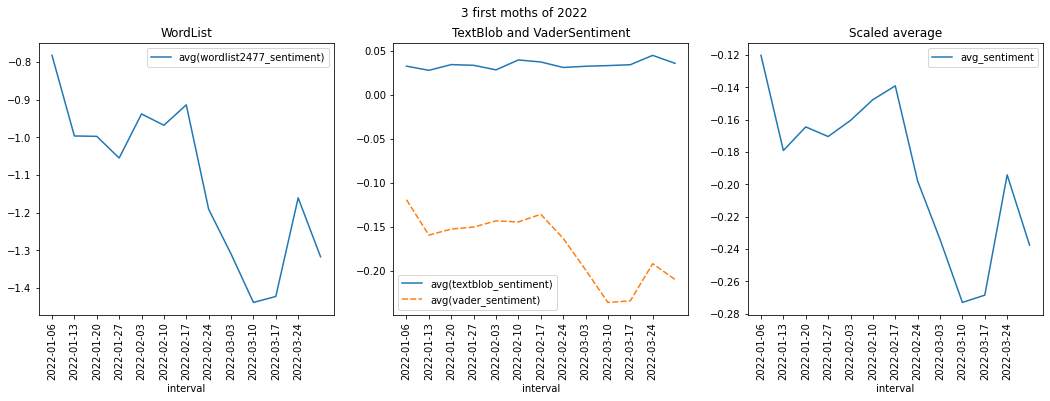

In [9]:
start_date = "2022-01-01 00:00:00"
end_date = "2022-04-01 00:00:00"

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('3 first moths of 2022')

for i in range(3):
    plot_events_sns(dfs[i], start_date=start_date, end_date=end_date, axes_i=axes[i], 
    title=titles[i],analysers=analysers[i], combine=combine_bools[i], x_tick_dist=7, xlab_rot=90)

Yearly all years

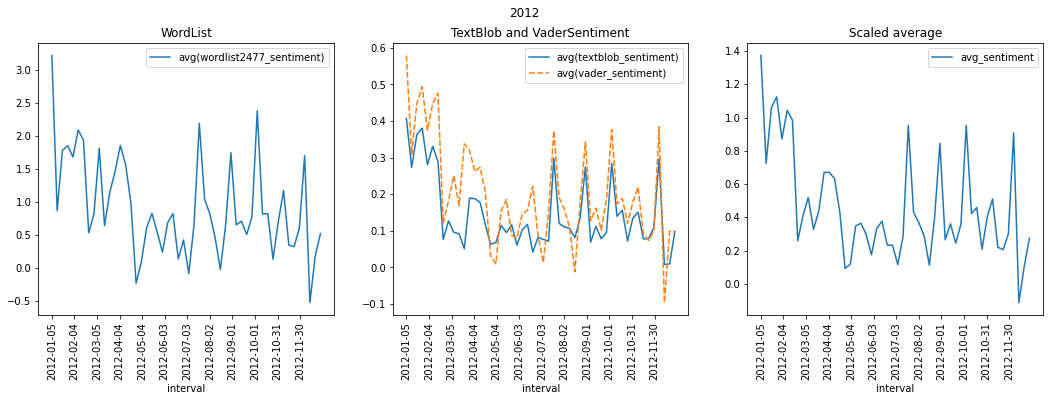

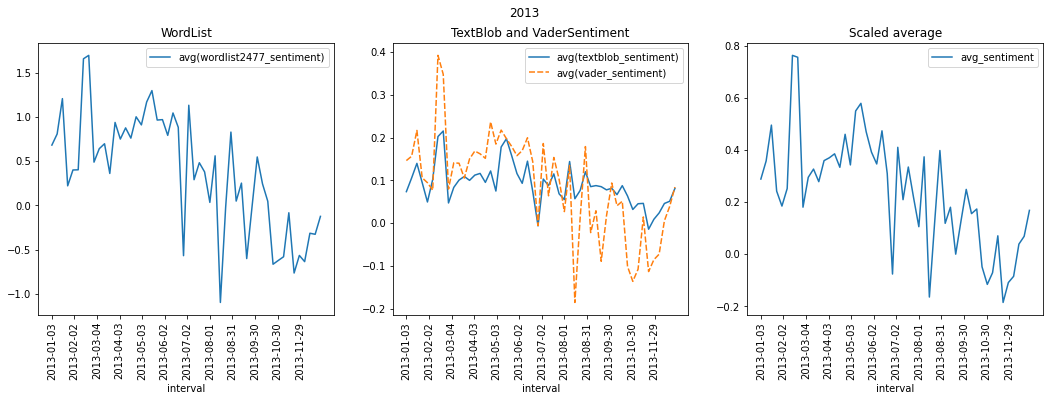

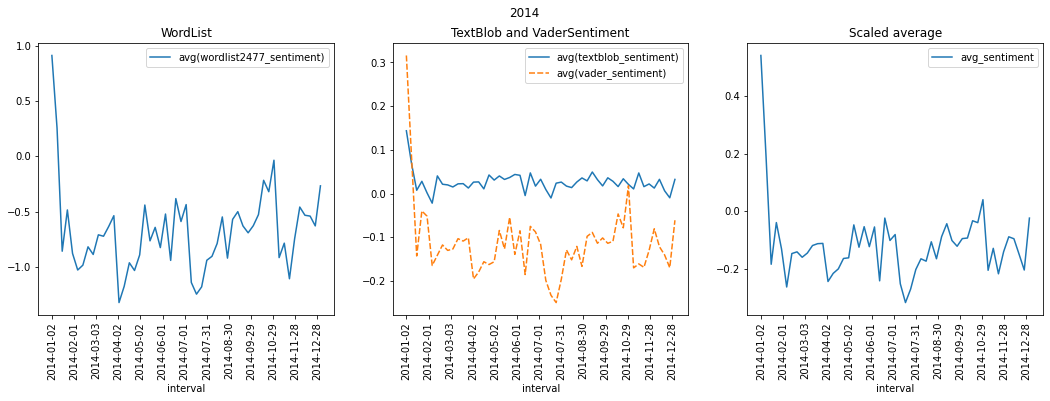

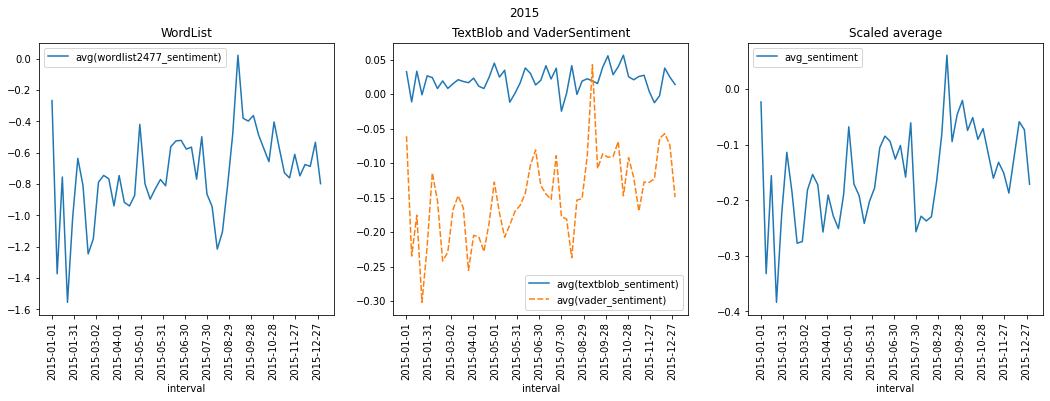

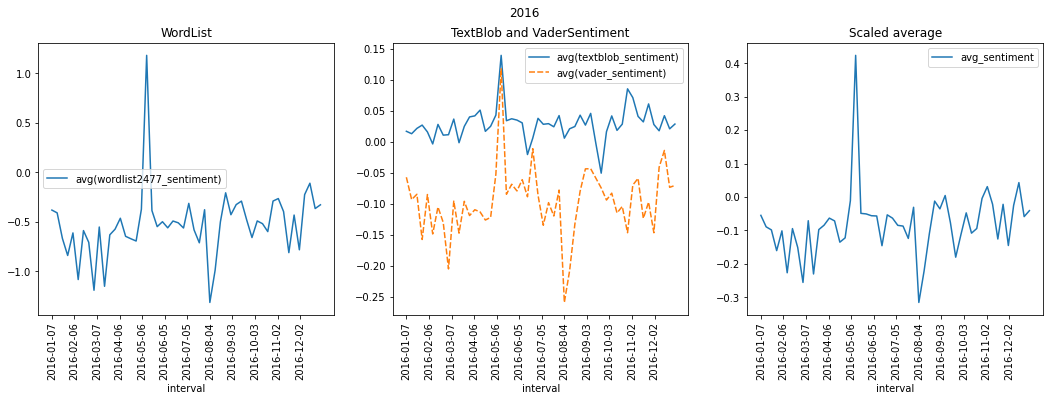

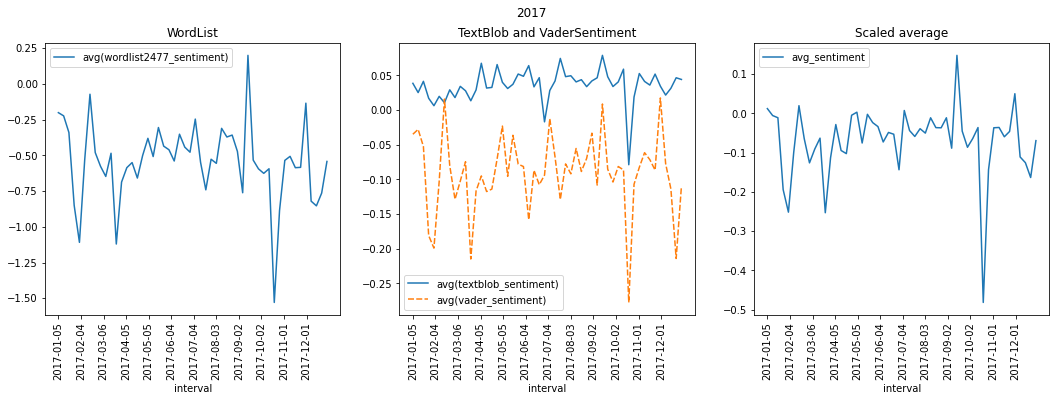

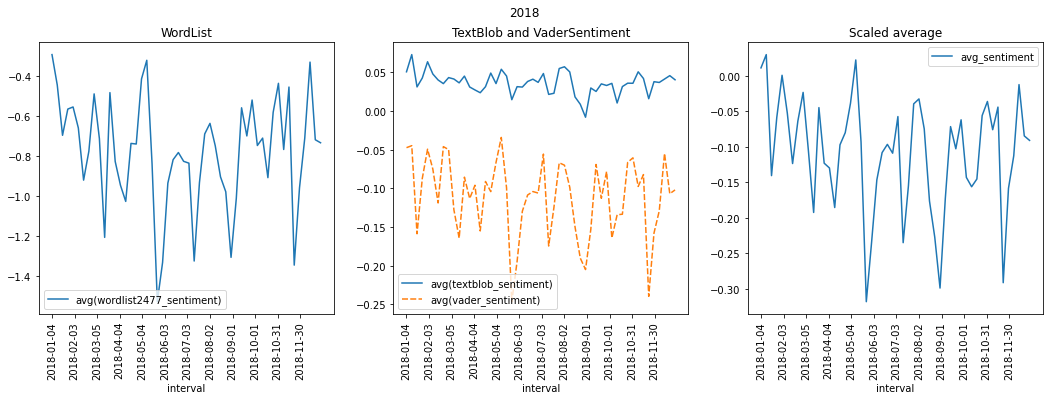

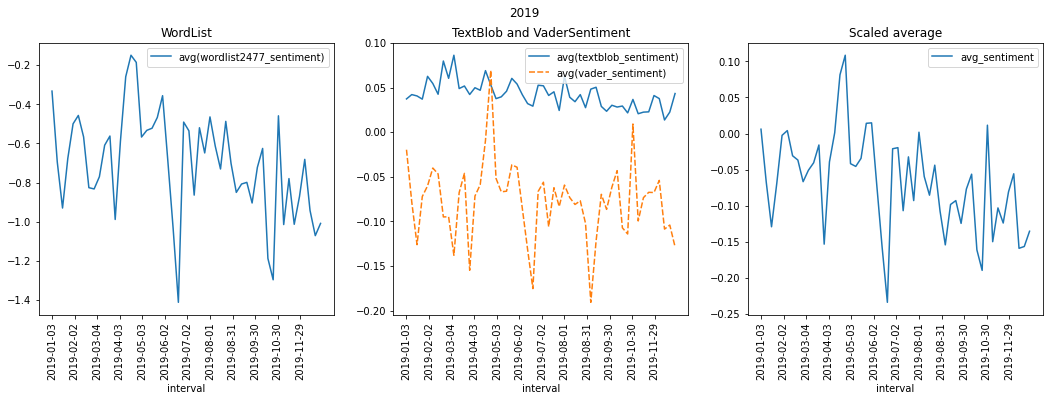

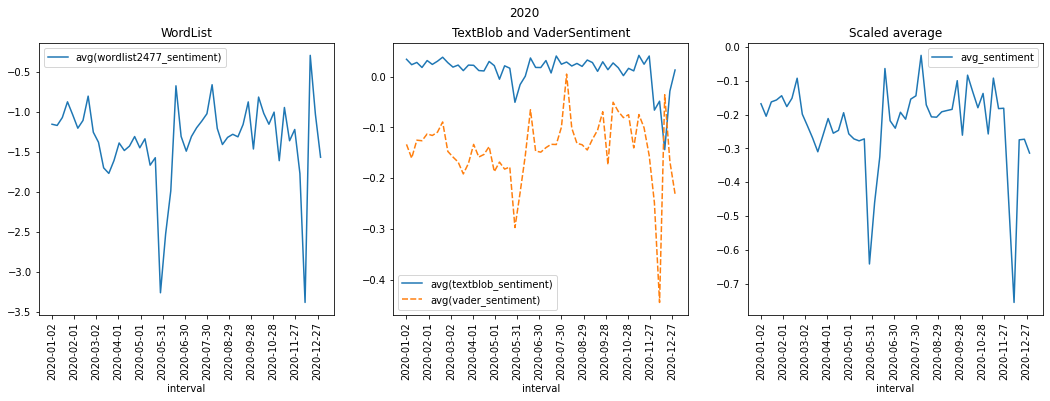

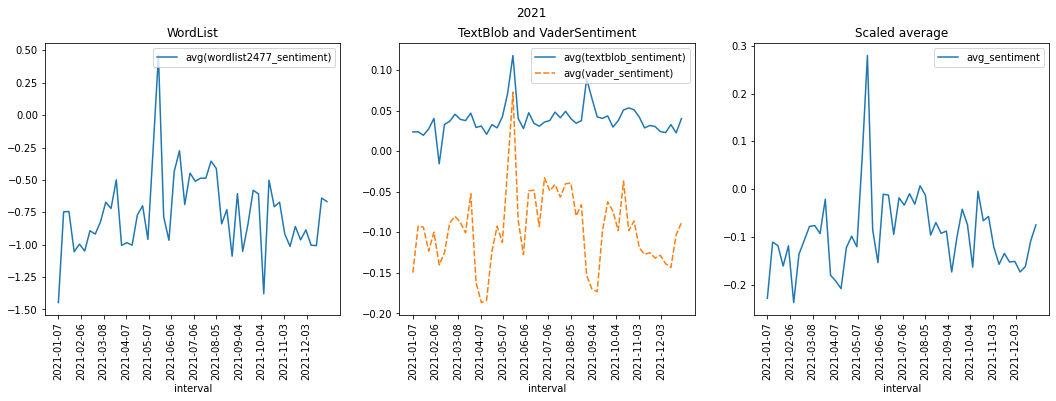

In [11]:
for year in range(2012, 2022):
    start = str(year) + '-01-01 00:00:00'
    end = str(year+1) + '-01-01 00:00:00'

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(str(year))
    for i in range(3):
        plot_events_sns(dfs[i], start_date=start, end_date=end, axes_i=axes[i], 
        title=titles[i],analysers=analysers[i], combine=combine_bools[i], x_tick_dist=30, xlab_rot=90)